In [3]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive/surely_not_sarcasm_data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers
!cp -r '$root/utils' .

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import get_linear_schedule_with_warmup

from utils.pytorch import train_model, test_model

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.1);

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# prepare data

In [4]:
df = pd.read_csv(root+'data/train_balanced_smaller.csv', usecols=['label', 'comment'])
df.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [5]:
X = df['comment'].values
y = df['label'].values

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.05, random_state=42)

In [7]:
X_train.shape, X_val.shape, X_test.shape

((768187,), (202155,), (40431,))

# distilbert

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [9]:
# lengths = [len(tokenizer.encode(x, max_length=512, truncation=True)) for x in X_train]
# plt.hist(lengths);

In [10]:
# np.quantile(lengths, 0.9)

In [11]:
max_len = 25

In [12]:
encoding_train = tokenizer.batch_encode_plus(
    list(X_train),
    add_special_tokens=True,
    max_length=max_len,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

encoding_val = tokenizer.batch_encode_plus(
    list(X_val),
    add_special_tokens=True,
    max_length=max_len,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

In [13]:
X_train, X_train_mask = encoding_train['input_ids'], encoding_train['attention_mask']
X_val, X_val_mask = encoding_val['input_ids'], encoding_val['attention_mask']

In [14]:
y_train, y_val = torch.tensor(y_train), torch.tensor(y_val)

In [15]:
batch_size = 128

train_data = TensorDataset(X_train, X_train_mask, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(X_val, X_val_mask, y_val)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [16]:
dataloaders = {'train': train_dataloader, 'val': val_dataloader}
data_size = {'train': len(train_data), 'val': len(val_data)}

In [17]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
).to(device);

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

In [18]:
epochs = 3
total_steps = len(train_dataloader) * epochs

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
criterion = torch.nn.CrossEntropyLoss()

In [19]:
best_model, history = train_model(model, criterion, optimizer, scheduler, epochs, dataloaders,
                                  data_size, device, rep=1000)


======== Epoch 1 / 3 ========
Training...
Batch 1,000 of 6,002. Elapsed: 518.40 s.
Batch 2,000 of 6,002. Elapsed: 1037.09 s.
Batch 3,000 of 6,002. Elapsed: 1555.67 s.
Batch 4,000 of 6,002. Elapsed: 2074.32 s.
Batch 5,000 of 6,002. Elapsed: 2591.65 s.
Batch 6,000 of 6,002. Elapsed: 3111.50 s.
== train == loss: 0.5152 accuracy: 0.7422
== val == loss: 0.4863 accuracy: 0.7624

======== Epoch 2 / 3 ========
Training...
Batch 1,000 of 6,002. Elapsed: 519.29 s.
Batch 2,000 of 6,002. Elapsed: 1040.01 s.
Batch 3,000 of 6,002. Elapsed: 1559.02 s.
Batch 4,000 of 6,002. Elapsed: 2079.33 s.
Batch 5,000 of 6,002. Elapsed: 2600.33 s.
Batch 6,000 of 6,002. Elapsed: 3121.27 s.
== train == loss: 0.4607 accuracy: 0.7807
== val == loss: 0.4831 accuracy: 0.7664

======== Epoch 3 / 3 ========
Training...
Batch 1,000 of 6,002. Elapsed: 521.44 s.
Batch 2,000 of 6,002. Elapsed: 1040.73 s.
Batch 3,000 of 6,002. Elapsed: 1558.30 s.
Batch 4,000 of 6,002. Elapsed: 2073.09 s.
Batch 5,000 of 6,002. Elapsed: 2587.95

In [20]:
torch.save(best_model.state_dict(), root+'models/distilbert.pth')

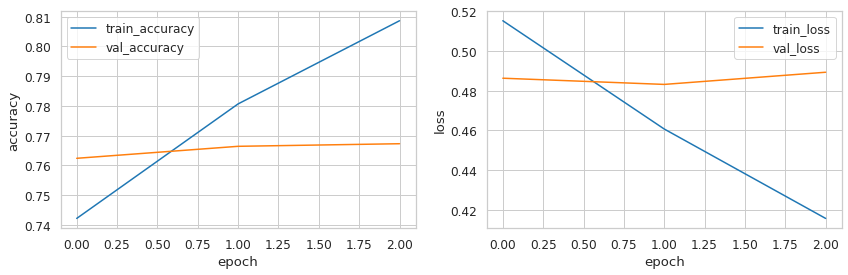

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))

for i, which in enumerate(['accuracy', 'loss']):
    ax = axes[i]
    ax.plot([float(tensor) for tensor in history['train_'+which]], label='train_'+which);
    ax.plot([float(tensor) for tensor in history['val_'+which]], label='val_'+which);
    ax.set_xlabel('epoch');
    ax.set_ylabel(which);
    ax.legend();